# The Annotated Gumbel-Softmax

Yao Fu, Columbia University | yao.fu@columbia.edu | Mon Mar 02nd 2020

### Background

The gumbel-softmax estimator is an increasingly popular estimator for the gradients over discrete samples. 
Although conceptually simple, hyper-parameter tuning is always a troublesome work in practice. 
What are the implementation detais of this estimator?
How to tune parameters of it?
In this notebook, we investigate this estimator from an engineering perspective, and reveal all the coding details of it. 

prerequisites
* [Auto-encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
* [Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/abs/1611.01144)
* [The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables](https://arxiv.org/abs/1611.00712)

We use a categorical VAE for mnist digits as our base model. This model encode an image $x$ to a latent code $z$ with the encoder $q_\phi(z|x)$, then decode it back to the image with the decoder $p_\theta(x|z)$. The ELBO ojbective is:

$$\mathcal{L} = \mathbb{E}_{q_\phi(z|x)}[p_\theta(x|z)] - \text{KL}[q_\phi(z|x) || p(z)]$$

Where $z$ is a discrete random variable. In optimization, generally, the gradient w.r.t $\phi$ through the discrete sample $z$ is intractable:

$$\nabla_\phi \mathbb{E}_{q_\phi(z|x)}[p_\theta(x|z)] $$

The reparameterization trick removes the stochasticity out from the computational graph by a deterministic mapping $z \sim q_\phi(z|x) = g(\phi, \epsilon), \epsilon \sim p(\epsilon)$ so we can backpropagate through the sampled $z$:

$$\nabla_\phi \mathbb{E}_{q_\phi(z|x)}[p_\theta(x|z)] = \nabla_\phi \mathbb{E}_{p(\epsilon)}[p_\theta(x|g(\phi, \epsilon))] $$

The gumbel-softmax further use a relaxed one-hot representation of $z$ to make the objective differentiable w.r.t. the categorical random variable. In this notebook, we implement gumbel-softmax from scratch and discuss the engineering details. 

Speciafically, we discuss 
* [Implementation of the Gumbel estimator](#Implementation-of-the-gumbel-estimator)
* [Training process](#Training-process)
* [Influence of the number of class](#Influence-of-the-number-of-class)
* [Interpretability and Controllability](#Interpretability-and-Controllability)
* [Strength of beta](#Strength-of-beta)
* [Influence of temperature annealing](#Influence-of-temperature-annealing)
* [Conclusion and best practice](#conclusion)

This notebook is, of course, inspired by Sasha Rush's _The Annotated Transformer_: https://nlp.seas.harvard.edu/2018/04/03/attention.html


In [224]:
import argparse
import torch
import torch.utils.data
import numpy as np

from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.distributions import OneHotCategorical

from tensorflow.examples.tutorials.mnist import input_data

In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

In [ ]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Implementation of the gumbel estimator

One detail is the difference between the log probability and logits predicted by the model. Generall we have:

`logits = linear(·)`

`prob = softmax(logits)`

`log_prob = log(prob)`

Then the `log_prob` is the input of the `sample_reparameterize` function:

`z_sample = sample_reparameterize(log_prob)`

However, in the original implementation from https://github.com/ericjang/gumbel-softmax/blob/master/gumbel_softmax_vae_v2.ipynb, it is the `logits` that is used as the input of the reparameterization function:

`z_sample = sample_reparameterize(logits)`

Will there be consequences that they use `logits` instead of `log_prob`? The answer is no. Here we explain why:

First, the `sample_reparameterize(·)` function is defined as: 

$$s = \text{sample_reparameterize}(a) = \text{softmax}((a + g) / \tau)$$

$$s_i = \frac{\exp((a_i + g_i)/ \tau)}{\sum_i \exp((a_i + g_i)/ \tau)}$$

We denote $s = $ `z_sample`, $a^* = $ `logits` or $a^\star = $ `log_prob`. $g$ is the gumbel noise.

One can easily show that there is a constant `C` difference between `logits` and `log_prob`

$$a^* = a^\star + C$$

`C` is determined by initialization and convergence path.

The standard implementation is to use `log_prob` as inputs, then the output is:


$$s^\star_i = \frac{\exp((a^\star_i + g_i)/ \tau)}{\sum_i \exp((a^\star_i + g_i)/ \tau)}$$

If we use `logits` as inputs, then the output is:
$$s^*_i = \frac{\exp((a^*_i + g_i)/ \tau)}{\sum_i \exp((a^*_i + g_i)/ \tau)}$$

We have: 
$$s^\star_i = \frac{\exp((a^\star_i + g_i)/ \tau)}{\sum_i \exp((a^\star_i + g_i)/ \tau)} = \frac{\exp((a^*_i + g_i + C)/ \tau)}{\sum_i \exp((a^*_i + g_i + C)/ \tau)} = \frac{\exp((a^*_i + g_i)/ \tau)}{\sum_i \exp((a^*_i + g_i)/ \tau)} = s^*_i$$


Note that the constant $C$ cancels out. So `logits` and `log_prob` would give us the sample output. In fact, the cancellation of $C$ is similar to the [log_sum_exp](https://en.wikipedia.org/wiki/LogSumExp) trick in the semiring algorithm. 

Conclusion: using `logits` or `log_prob` will give the same output. 

In [229]:
def sample_gumbel(shape, eps=1e-20):
  U = torch.rand(shape)
  return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(log_p, tau):
  g = sample_gumbel(log_p.size())
  gumbel_perturbed_log_p = log_p + g
  z = F.softmax(gumbel_perturbed_log_p / tau, dim=-1)
  return z
  
class CategoricalVAE(nn.Module):
  def __init__(self, num_class, num_sample, beta_z):
    super(CategoricalVAE, self).__init__()
    
    self.num_sample = num_sample
    self.beta_z = beta_z

    self.fc1 = nn.Linear(784, 400)
    self.fc2 = nn.Linear(400, num_class)
    self.fc3 = nn.Linear(num_class, 400)
    self.fc4 = nn.Linear(400, 784)
    return

  def encode(self, x):
    """NOTE: the difference between the logits and the log_prob in this function"""
    h1 = F.relu(self.fc1(x))
    logits = self.fc2(h1)
    q_prob = F.softmax(logits, dim=-1)
    log_q_prob = torch.log(q_prob + 1e-10)
    return q_prob, log_q_prob

  def sample_reparameterize(self, log_p, tau):
    z = gumbel_softmax_sample(log_p, tau)
    return z

  def decode(self, z):
    h3 = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h3))

  def forward_gumbel(self, x, tau=1.0):
    q_prob, log_q_prob = self.encode(x)
    
    # the entropy of z 
    ent_z = -(q_prob * log_q_prob).sum(dim=1).mean()
    
    z = self.sample_reparameterize(log_q_prob, tau)
    x_out = self.decode(z)
    
    nll_x = F.binary_cross_entropy(x_out, x, reduction='mean')
    loss = nll_x - self.beta_z * ent_z 
    return loss, nll_x, ent_z, z

# Training 

We investigate the influence of different hyper parameters specified by the `config` dictionary

In [269]:
def visualize(config, model):
  z = np.eye(config['num_class'])
  x = model.decode(torch.from_numpy(z).type(torch.float))
  x = x.view(config['num_class'], 28, 28).detach().numpy()
  
  if(config['num_class'] > 10):
    img_0 = np.hstack([x[i] for i in range(int(config['num_class'] / 2))])
    img_1 = np.hstack([x[i] for i in range(int(config['num_class'] / 2), config['num_class'])])
    img = np.vstack([img_0, img_1])
  else:
    img = np.hstack([x[i] for i in range(config['num_class'])])
  plt.imshow(img)
  plt.show()
  return

def print_at(i):
  if(i % 2000 == 0): return True
  elif(i == 9999): return True
  return False

def train(config, print_log=True):
  model = CategoricalVAE(config['num_class'], config['num_sample'], config['beta_z'])
  params = list(model.parameters())
  opt = Adam(params, 1e-3)

  batch_size = 50
  num_iter = 10000

  tau_start = 1.0
  tau_final = 0.01
  tau_interval = (tau_start - tau_final) / num_iter

  nll_x_log = []
  ent_z_log = []

  for i in range(num_iter):
    x, y = mnist.train.next_batch(batch_size)

    model.zero_grad()
    if(config['anneal_tau']): tau = tau_start - i * tau_interval
    else: tau = tau_start
    loss, nll_x, ent_z, z = model.forward_gumbel(torch.from_numpy(x), tau)
    loss.backward()
    opt.step()

    nll_x = float(nll_x.detach().cpu().numpy())
    ent_z = float(ent_z.detach().cpu().numpy())
    nll_x_log.append(nll_x)
    ent_z_log.append(ent_z)

    if(print_at(i)):
      if(print_log):
        loss = loss.detach().cpu().numpy()
        z = z.detach().numpy()
        print('step %d, nll_x %.4g, ent_z %.4g, tau %.4g' % (i, nll_x, ent_z, tau))
        print('sample looks like:')
        print(z[0])
        print(z[1])
        print('sampled z index are:', z.argmax(1))
      else: print('.')

  print('finished!')
  
  visualize(config, model)
  return model, np.array(nll_x_log), np.array(ent_z_log)

# Training process

We keep the output log here. Please pay attention to the decreasing `nll`, the decreasing `ent_z`, the annealing of `tau`, and the corresponding `z_sample`

step 0, nll_x 0.6932, ent_z 2.297, tau 1
sample looks like:
[0.0581615  0.03164273 0.12765352 0.25653735 0.02614828 0.10506605
 0.16808088 0.12228893 0.08446766 0.01995309]
[0.269303   0.01329175 0.12347159 0.04548633 0.03982688 0.20237905
 0.1966563  0.03896324 0.04795464 0.02266724]
sampled z index are: [3 0 6 9 6 4 4 2 0 2 8 0 1 7 8 2 6 3 4 7 0 9 9 2 1 0 5 5 1 9 2 0 3 2 2 2 6
 3 7 6 9 2 3 4 2 3 7 2 5 0]
step 2000, nll_x 0.2096, ent_z 0.6298, tau 0.802
sample looks like:
[2.3107560e-07 3.5829048e-06 1.8054833e-06 6.7814443e-07 3.7685117e-05
 7.5302074e-07 1.4470739e-04 1.3262162e-06 5.2856416e-07 9.9980885e-01]
[2.5160497e-04 1.4926243e-02 6.4737840e-05 4.2319276e-05 9.2246234e-01
 2.6531273e-04 4.1556254e-04 4.9971133e-02 1.0323420e-02 1.2772662e-03]
sampled z index are: [9 4 3 9 2 5 4 6 8 6 3 7 7 6 0 7 7 4 5 7 4 3 2 6 5 3 5 3 0 3 8 9 3 2 2 7 6
 5 7 4 3 3 6 8 7 3 7 9 3 9]
step 4000, nll_x 0.2063, ent_z 0.7659, tau 0.604
sample looks like:
[1.2005896e-03 9.0272033e-01 1.5312715e-03 1

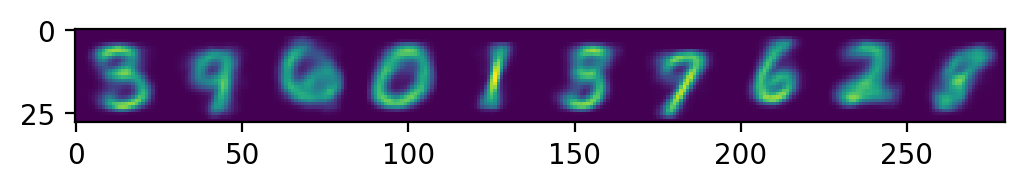

In [254]:
config = {'max_grad_norm': 5.0, 
          'num_class': 10, 
          'num_sample': 3, 
          'beta_z': 0.01,
          'anneal_tau': True}

model, nll_x_log, ent_z_log = train(config)

As we can see from the above training log, as the model converges, the samples look more like one-hot:
* In step 0, samples are completely not one-hot. This is why we call them the continuous relaxation
* In the middle steps, except the peak number, the magnitude of other numbers in the samples is decreasing: about 1e-5 at step 2000, 1e-15 at step 6000, 1e-20 at step 8000
* In step 9999, the final step, since `tau` is annealed to 1e-2, the samples anneal to one-hot

# Influence of the number of class

Question: if we set the number of class to 10, will the model output 10 different digits?

Answer: no, as we can see that in the previous run, `z = 0` and `z = 5` all decode to the digit `3`. The different class `z` will represent different **modes** of the distribution of `x`, instead of different numbers.

We can also obeserve the **Permutation Invariance** of the NLL loss if we run the above cell multiple times. This is to say, we cannot expect that `z = 0` decodes the digit `0`, `z = 1` decode the digit `1` ... In fact, `z = i` could correspond to any digit `j`. The permutation of `z` does not change the NLL convergence

TODO: breaking the symmetry with an ordered prior (not included in this post)

We will see if we increase the number of class, more modes (type of digits and shape of them) would be discovered

.
.
.
.
.
.
finished!


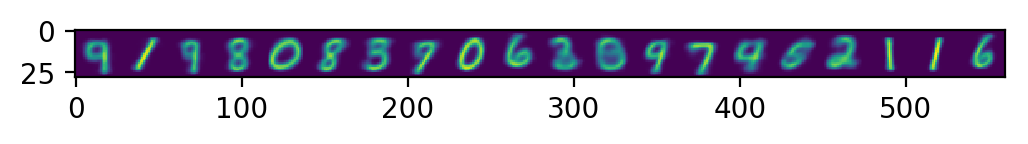

In [263]:
config = {'max_grad_norm': 5.0, 
          'num_class': 20, 
          'num_sample': 3, 
          'beta_z': 0.01,
          'anneal_tau': True}

model_more_class, nll_x_log, ent_z_log = train(config, print_log=False)

note that in the above example, different shapes of `1` are discovered

**Conclusion: the number of class represents different _modes_ in the distribution of `x`, instead of different _digit_**

# Interpretability and Controllability

The advantage of using a discrete representation is that we can associate each latent class with one typical output, and we can control the output but controlling the latent. This is to say, we can manually set the latent index, and let the model to output the corresponding digits. 

The interpretability is shown by the above examples as `z_i` represents the type and shape of digits.

This controllability is demonstrated in the following examples as we set `z` manually. There are noise added to the samples to induce variance of the output digits

In [249]:
def visualize_sample(config, model, z, sample_size=10):
  z_in = torch.from_numpy(z).type(torch.float).unsqueeze(0).repeat(sample_size, 1)
  z = z_in + 0.03 * torch.rand(z_in.size())
  z /= z.sum(dim=1, keepdim=True)
  x = model.decode(z)
  x = x.view(sample_size, 28, 28).detach().numpy()
  
  img = np.hstack([x[i] for i in range(sample_size)])
  plt.imshow(img)
  plt.show()
  return

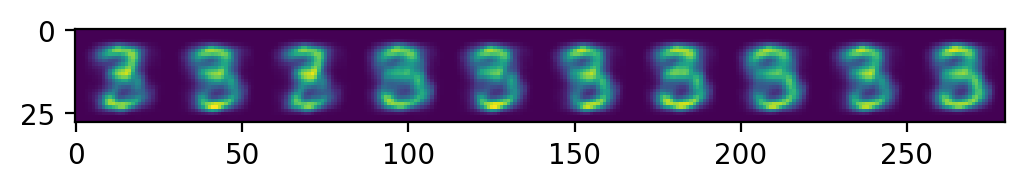

In [255]:
# setting z = 0
z = np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
visualize_sample(config, model, z)

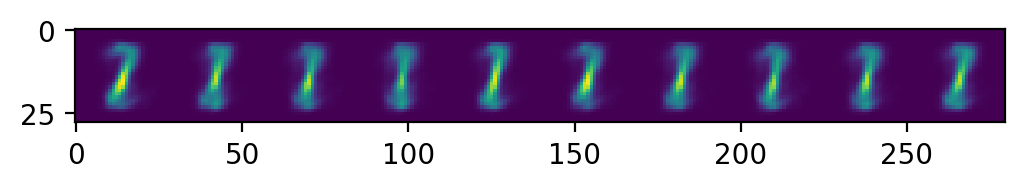

In [256]:
# setting z = 4
z = np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
visualize_sample(config, model, z)

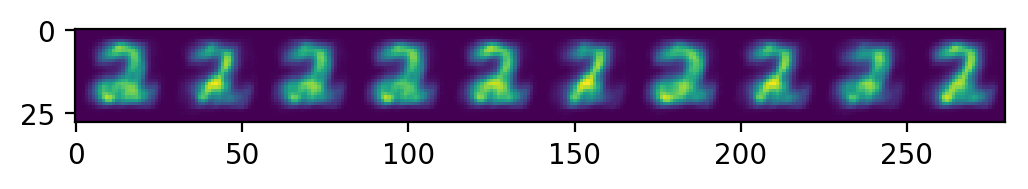

In [257]:
# setting z = 8
z = np.array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
visualize_sample(config, model, z)

As we can observe from the above samples, setting a fixed `z` will decode the corresponding digit, and adding noise to the one hot representation of `z` will induce slight variance of the generated digtis. In the last example, the digits change from `2` to `7`

# Strength of beta

`beta_z` is used to regularize the KL divergence between the poseterior and a uniform prior

As we will demonstrate, the stability of training is quite sensitive to the beta parameter. **Too large beta or too small beta will both lead to posterior collapse**

.
.
.
.
.
.
finished!


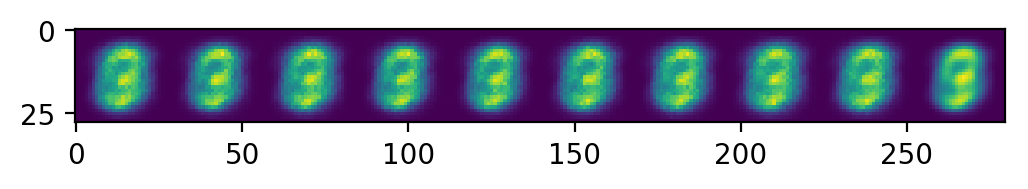

In [260]:
config = {'max_grad_norm': 5.0, 
          'num_class': 10, 
          'num_sample': 3, 
          'beta_z': 0.00,
          'anneal_tau': True}

model, nll_x_log, ent_z_log = train(config, print_log=False)

.
.
.
.
.
.
finished!


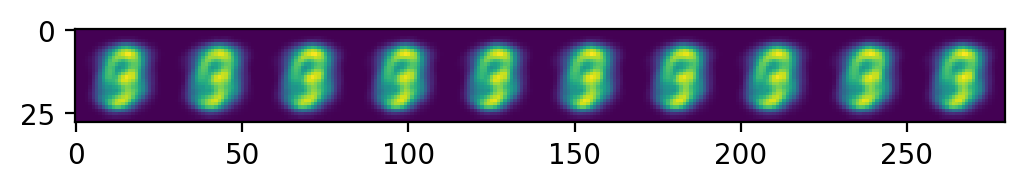

In [262]:
config = {'max_grad_norm': 5.0, 
          'num_class': 10, 
          'num_sample': 3, 
          'beta_z': 0.1,
          'anneal_tau': True}

model, nll_x_log, ent_z_log = train(config, print_log=False)

In the above examples, setting `beta_z` to `0.00` or `0.1` both lead to posterior collapse, i.e. the decoder ignores the code `z` and just models the unconditional likelihood. After convergence, the model outputs something like the average of all the mnist digits.

Note that this is different with a Gaussian VAE. In that case, setting `beta_z` too small would NOT induce posterior collapse, only a large `beta_z` will do.

**Conclusion: set `beta_z` carefully for a discrete latent variable**

# Influence of temperature annealing

Without annealing, there will be a gap between the `z` samples in training and inference. Specially, in training, the `z`s are quite relaxed like:

`z_sample = [0.01, 0.01, 0.25, 0.70, 0.03]`

In inference, we pass one hot `z`s:

`z_sample = [0.00, 0.00, 0.00, 1.00, 0.00]`

Q: if we do not anneal tau, can use still pass one hot `z`s during inference and get legible outputs?

A: yes

.
.
.
.
.
.
finished!


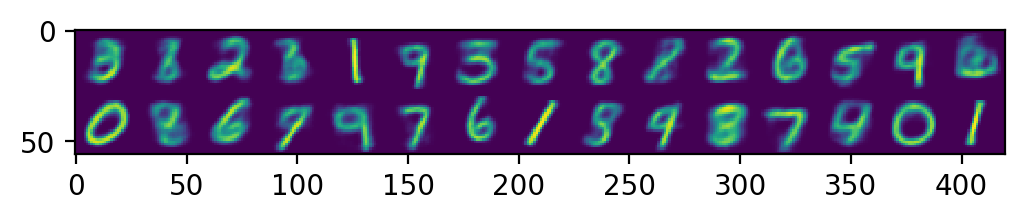

In [270]:
config = {'num_class': 30, 
          'num_sample': 3, 
          'beta_z': 0.01,
          'anneal_tau': False}

model_no_anneal, nll_x_log_no_anneal, ent_z_log_no_anneal = train(config, print_log=False)

If we do not anneal tau, then the sample would NOT be one hot. However, during inference, if we pass one hot z to the decoder, it still outputs recognizable digits

.
.
.
.
.
.
finished!


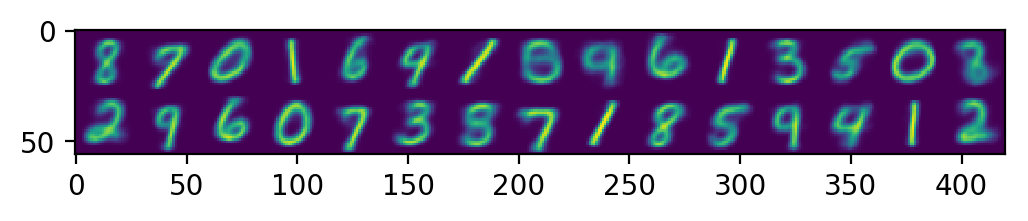

In [272]:
config = {'num_class': 30, 
          'num_sample': 3, 
          'beta_z': 0.01,
          'anneal_tau': True}

model_anneal, nll_x_log_anneal, ent_z_log_anneal = train(config, print_log=False)

If we anneal tau, then the sample would be quite close to one hot. During inference, we pass one hot z to the decoder (as we should), it of course outputs recognizable digits

In [275]:
def compare_model_outputs(model_0, model_1, config):
  z = np.eye(config['num_class'])
  x_0 = model_0.decode(torch.from_numpy(z).type(torch.float))
  x_0 = x_0.view(config['num_class'], 28, 28).detach().numpy()
  
  z = np.eye(config['num_class'])
  x_1 = model_1.decode(torch.from_numpy(z).type(torch.float))
  x_1 = x_1.view(config['num_class'], 28, 28).detach().numpy()
  
  img_0 = np.hstack([x_0[i] for i in range(int(config['num_class'] / 2))])
  img_1 = np.hstack([x_0[i] for i in range(int(config['num_class'] / 2), config['num_class'])])
  img_x = np.zeros_like(img_1)
  img_2 = np.hstack([x_1[i] for i in range(int(config['num_class'] / 2))])
  img_3 = np.hstack([x_1[i] for i in range(int(config['num_class'] / 2), config['num_class'])])
  
  img = np.vstack([img_0, img_1, img_x, img_2, img_3])
  plt.imshow(img)
  plt.show()
  return

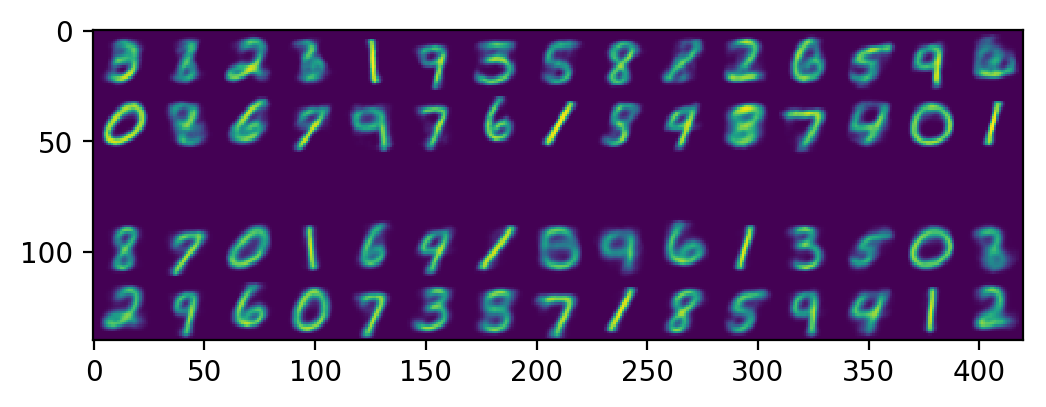

In [276]:
compare_model_outputs(model_no_anneal, model_anneal, config)

The upper two lines are outputs without tau annealing, the lower two lines are samples with tau annealing.

Question: is the second line better than the first line?

Answer: Probabily. 

Generally many samples are the same good. However we do observe that in the upper part, there are more digits with bad quality: digits at location (1, 1), (1, 2), (1, 4), (1. 10), (1, 15), (2, 9) are vague. In contrast, in samples from the lower part, only digits at location (3, 8), (3, 15), (4, 13) are vague. 

**Conclusion: annealing gives a better controllability**

**Note: this conclusion will be more clear in a real-world NLP task**

Generally, in NLP, the one-hot encoding will induce a word embedding, and the relaxed encoding will induce a mixture of different word embeddings. Downstream tasks will then be influenced from both performance and controllability perspectives.

In [277]:
def compare_training_curve(curve_0, curve_1):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
  f.set_size_inches(8, 2, forward=True)
  x = np.arange(len(curve_0))
  ax1.plot(x, curve_0)
  ax2.plot(x, curve_1)
  plt.show()
  return

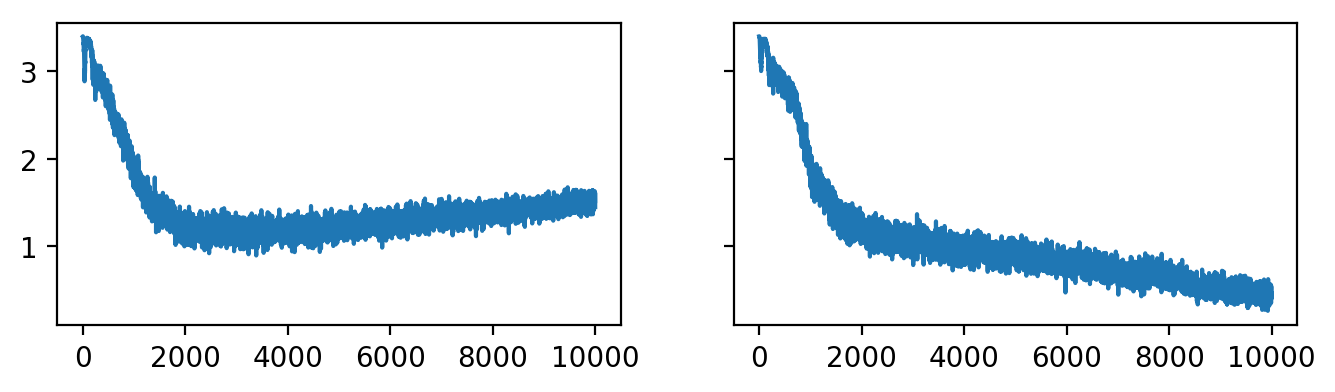

In [278]:
compare_training_curve(ent_z_log_no_anneal, ent_z_log_anneal)

This is just a sidenote showing that annealing helps with regularization

# Conclusion

* As you can see from this post, although the gumbel-softmax seems to be simple, in practice there are many considerations, even on the super-simple mnist dataset 
* There are usually more issues when the gumbel estimator is used in NLP tasks, and many of them are rooted from the discussions in this post. 
* The `beta_z` parameter should be tuned with care, it cannot be too small or too large as either would induce posterior collapse
* Annealing of temperature helps with the controllability. Although this conclusion is not that strong in this post,  in NLP practice we observe a lot of unsuccessful controllability due to bad annealing. So it should be treated with care
* With the right training techniques, we can achieve interpretability and controllability with a discrete latent variable